In [4]:
from articlehelper import ArticleHandler, RePostprocessor, map_paragraphs, map_category_ukrpravda
import numpy as np
import pandas as pd
from clfhelpers import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, mutual_info_score, adjusted_mutual_info_score
from analyzers import PosAnalyzer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif

MASK = "data\\news"
zip_fname = MASK + '.zip'
train_fname = MASK + '_train.txt'
test_fname = MASK + '_test.txt'

In [2]:
train = ArticleHandler.read_zip_list(zip_fname, train_fname) 
print(len(train))
test = ArticleHandler.read_zip_list(zip_fname, test_fname)
print(len(test))

2250
750


In [5]:
df_train = pd.DataFrame.from_dict(map_paragraphs(train, map_category_ukrpravda))
df_train.groupby(['category']).count()


,doc,text
category,,
articles,15584,15584
blog,10150,10150
columns,11328,11328
news,10900,10900


In [6]:
df_test = pd.DataFrame.from_dict(map_paragraphs(test, map_category_ukrpravda))
df_test.groupby(['category']).count()

,doc,text
category,,
articles,4828,4828
blog,3235,3235
columns,4092,4092
news,3832,3832


In [7]:
X_train = df_train['text'].values
X_test = df_test['text'].values
y_train = df_train['category'].values
y_test = df_test['category'].values

In [8]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

47962 15987 47962 15987


In [9]:
class ClfFactoryPOS:
    def get_analyzer(self):
        return PosAnalyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

factory = ClfFactoryPOS()
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))   

Після річної перерви в Україні стартували публічні закупівлі енергосервісу.
У листопаді пошук видає 81 оголошення про закупівлі цієї послуги для комунальних установ Київської, Сумської та Миколаївської областей.
Morphology initialized for uk
['<P>', '<P>', '<P>', 'ADVB', 'ADJF', 'NOUN', 'PREP', 'NOUN', 'VERB', 'ADJF', 'NOUN', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'PREP', 'NOUN', 'NOUN', 'VERB', 'NUMBER', 'NOUN', 'NOUN', 'NOUN', 'NPRO', 'NOUN', 'PREP', 'ADJF', 'NOUN', 'ADJF', ',', 'ADJF', 'CONJ', 'ADJF', 'NOUN', '.', '</P>', '</P>', '</P>']


In [10]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [11]:
print(vtrain.shape, vtest.shape)

(47962, 17754) (15987, 17754)


In [12]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.46      0.57      0.51      4828
       blog       0.54      0.39      0.45      3235
    columns       0.45      0.38      0.41      4092
       news       0.66      0.74      0.69      3832

avg / total       0.52      0.52      0.52     15987

0.16085149510410454


In [13]:
show_all_top_features(tfidf, clf, n=40)

articles:
NOUN NOUN: -4.956149183307669
<P> <P>: -5.123331901747159
</P> </P>: -5.123331901747159
ADJF NOUN: -5.171509611318108
NOUN ,: -5.419911353153296
NOUN .: -5.566648648936145
PREP NOUN: -5.578238303671445
VERB NOUN: -5.597205494122717
NOUN VERB: -5.654224464510208
NPRO NOUN: -5.802253690933879
<P> <P> <P>: -5.816414595792163
</P> </P> </P>: -5.816414595792163
NOUN ADJF: -5.8198426826390355
NOUN PREP: -5.820613157464931
NOUN NOUN NOUN: -5.879781688333703
, CONJ: -5.8954847347543735
NPRO VERB: -5.907022217377523
. </P> </P> </P>: -5.907930661381571
. </P> </P>: -5.907930661381571
. </P>: -5.907930661381571
PRCL VERB: -6.003788715491305
NOUN . </P> </P>: -6.014071890504556
NOUN . </P>: -6.014071890504556
NOUN ": -6.046984976505712
CONJ NOUN: -6.070513564024436
NOUN ADJF NOUN: -6.073047159512261
NOUN PREP NOUN: -6.1243539814932655
NOUN CONJ: -6.142679982316664
VERB ,: -6.235435885224367
VERB ADJF: -6.263477279732965
ADJF NOUN .: -6.264619196022611
, NOUN: -6.2703757221956895
PREP AD

In [14]:
percentile = 60
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

             precision    recall  f1-score   support

   articles       0.46      0.60      0.52      4828
       blog       0.54      0.37      0.44      3235
    columns       0.46      0.36      0.40      4092
       news       0.66      0.73      0.69      3832

avg / total       0.52      0.52      0.51     15987

0.15683756318309747


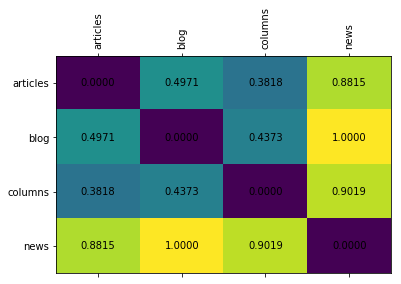

In [15]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [16]:
show_all_top_features(tfidf, clf, n=40)

articles:
ADJF UNDEF UNDEF UNDEF: -4.900566028468754
, PRED CONJ: -5.067748746908244
, PRCL NPRO VERB: -5.067748746908244
. NPRO PRCL PREP: -5.115926456479192
ADJF ADJF , NOUN: -5.3643281983143805
ADJF CONJ VERB NPRO: -5.511065494097229
INTJ NUMBER ADJF NOUN: -5.52265514883253
NOUN ADVB VERB VERB: -5.541622339283801
ADVB NOUN UNDEF PRCL: -5.598641309671293
ADVB VERB VERB NOUN: -5.746670536094964
, PREP ADJF NOUN: -5.760831440953248
, PRCL NUMBER: -5.760831440953248
ADJF NOUN ADVB NPRO: -5.76425952780012
ADVB ADVB VERB ADJF: -5.765030002626015
ADVB , ": -5.824198533494788
" VERB PREP NOUN: -5.839901579915458
CONJ CONJ ADVB ADVB: -5.851439062538607
, CONJ NOUN INTJ: -5.852347506542656
, CONJ NOUN CONJ: -5.852347506542656
, CONJ NOUN ADVB: -5.852347506542656
INTJ ADJF NOUN .: -5.94820556065239
ADJF INTJ ,: -5.95848873566564
ADJF INTJ ": -5.95848873566564
ADJF , CONJ NOUN: -5.991401821666797
<P> NOUN .: -6.014930409185521
ADJF NOUN NOUN VERB: -6.017464004673346
ADVB CONJ NOUN: -6.068770826

In [17]:
for doc in test:
    doc['category'] = map_category_ukrpravda(doc)
df_test = pd.DataFrame.from_dict(test)
df_test.groupby(['category']).count()

,authors,authors_description,autocategory,body,date,filename,language,tags,text,title,url
category,,,,,,,,,,,
articles,37,0,88,88,34,88,88,24,88,33,88
blog,150,150,150,150,150,150,150,150,150,150,150
columns,36,0,112,112,76,112,112,42,112,51,112
news,0,0,400,400,384,400,400,365,400,384,400


In [18]:
X_test = df_test['text'].values
y_test = df_test['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

             precision    recall  f1-score   support

   articles       0.45      0.76      0.56        88
       blog       0.97      0.51      0.67       150
    columns       0.69      0.77      0.73       112
       news       0.97      0.96      0.97       400

avg / total       0.87      0.82      0.82       750

0.5939945588637918


In [19]:
# from sklearn.externals import joblib
# joblib.dump(clf, 'clf_news_MNB_POS.pkl') 
# joblib.dump(tfidf, 'tfidf_news_MNB_POS.pkl')
# joblib.dump(sel_perc, 'featsel_news_MNB_POS.pkl')